<a href="https://colab.research.google.com/github/KilluJ/nlp-projects/blob/main/Rating%20Classifier%20using%20summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#preprocess the .json file
import pandas as pd

df = pd.read_json('reviews.json', lines=True)
data = df[["summary", "overall"]]

#equally split the train set and the test set
train, test = data[:len(data)//2], data[len(data)//2:]

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [3]:
#make new directory to store .text files for each review under each rating group
train_dir, test_dir = './train_s', './test_s'
os.mkdir(train_dir)
os.mkdir(test_dir)

#make new directory for each rating group
for k in set(train["overall"]):
    os.mkdir(os.path.join(train_dir, str(k)))
    os.mkdir(os.path.join(test_dir, str(k)))

#convert each review to a .text file for training set
for index, row in train.iterrows():
    curdir = os.path.join(train_dir, str(row['overall']))
    curname = str(row['overall']) + str(index) + '.txt'
    f = open(os.path.join(curdir, curname), 'w', encoding='utf-8')
    f.write(row['summary'])
    f.close()

#convert each review to a .text file for testing set
for index, row in test.iterrows():
    curdir = os.path.join(test_dir, str(row['overall']))
    curname = str(row['overall']) + str(index) + '.txt'
    f = open(os.path.join(curdir, curname), 'w', encoding='utf-8')
    f.write(row['summary'])
    f.close()

In [4]:
#check for a random review rated 1/5
sample_file = os.path.join(train_dir, '1/1100261.txt')
with open(sample_file) as f:
  print(f.read())

Worthless for presta valves


In [5]:
#preparing input for training set
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    './train_s',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 148168 files belonging to 5 classes.
Using 118535 files for training.


In [6]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'Like it!'
Label 4
Review b'comfortable'
Label 3
Review b'Could be used as a Blanket (X-Large Size)'
Label 4


In [7]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])
print("Label 4 corresponds to", raw_train_ds.class_names[4])

Label 0 corresponds to 1
Label 1 corresponds to 2
Label 2 corresponds to 3
Label 3 corresponds to 4
Label 4 corresponds to 5


In [8]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    './train_s',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    './test_s',
    batch_size=batch_size)

Found 148168 files belonging to 5 classes.
Using 29633 files for validation.
Found 148169 files belonging to 5 classes.


In [9]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
#vectorize the input
max_features = 1000
sequence_length = 50

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [10]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great family fun', shape=(), dtype=string)
Label 5
Vectorized review (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  2,   1, 131,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>, <tf.Tensor: shape=(), dtype=int32, numpy=4>)


In [11]:
print("926 ---> ",vectorize_layer.get_vocabulary()[926])
print("127 ---> ",vectorize_layer.get_vocabulary()[127])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

926 --->  adapter
127 --->  belt
Vocabulary size: 1000


In [12]:
#do the final vectorization for each data group
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
#define our model
embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.4),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          16000     
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 5)                 85        
                                                                 
Total params: 16085 (62.83 KB)
Trainable params: 16085 (62.83 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [14]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',
              metrics=['accuracy'])

In [15]:
#start training
epochs = 15

checkpoint_filepath = './checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.002, patience=0)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback, earlystop_callback])

Epoch 1/15
3705/3705 [==============================] - 28s 7ms/step - loss: 1.0288 - accuracy: 0.6400 - val_loss: 0.9671 - val_accuracy: 0.6433
Epoch 2/15
3705/3705 [==============================] - 35s 10ms/step - loss: 0.9351 - accuracy: 0.6505 - val_loss: 0.9038 - val_accuracy: 0.6564
Epoch 3/15
3705/3705 [==============================] - 13s 3ms/step - loss: 0.8951 - accuracy: 0.6584 - val_loss: 0.8756 - val_accuracy: 0.6666
Epoch 4/15
3705/3705 [==============================] - 14s 4ms/step - loss: 0.8735 - accuracy: 0.6641 - val_loss: 0.8601 - val_accuracy: 0.6712
Epoch 5/15
3705/3705 [==============================] - 15s 4ms/step - loss: 0.8624 - accuracy: 0.6680 - val_loss: 0.8518 - val_accuracy: 0.6756
Epoch 6/15
3705/3705 [==============================] - 13s 3ms/step - loss: 0.8542 - accuracy: 0.6713 - val_loss: 0.8464 - val_accuracy: 0.6771
Epoch 7/15
3705/3705 [==============================] - 13s 4ms/step - loss: 0.8497 - accuracy: 0.6729 - val_loss: 0.8428 - val_a

In [16]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

4631/4631 [==============================] - 22s 5ms/step - loss: 0.8460 - accuracy: 0.6709
Loss:  0.8460015058517456
Accuracy:  0.6708690524101257


In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

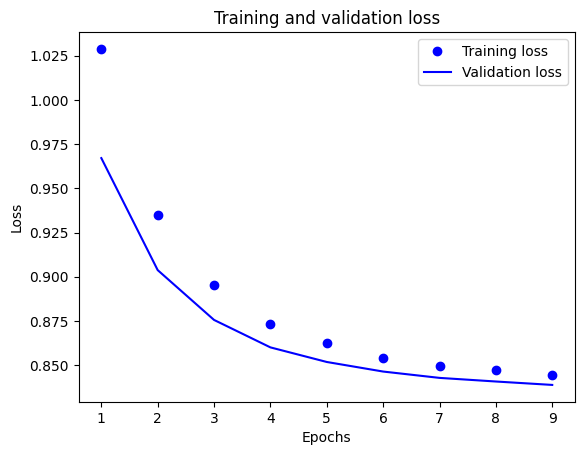

In [18]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

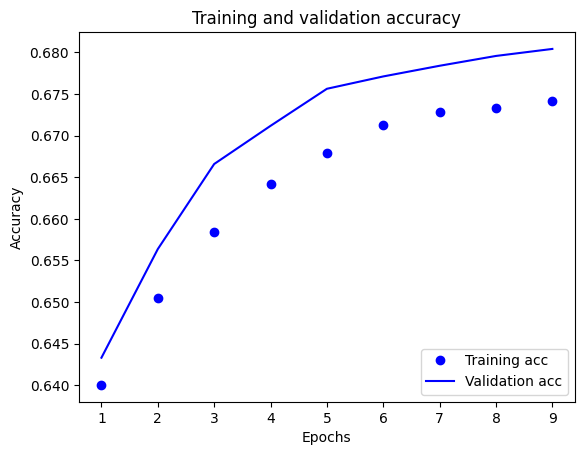

In [19]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [20]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

4631/4631 [==============================] - 17s 4ms/step - loss: 1.3028 - accuracy: 0.6709
0.6708690524101257


In [21]:
#the examples are randomwly picked from the original .json file
examples = [
  "Seems okay.", #3
  "Love love love!", #5
  "Great for my device", #4
    "perfect.", #5
    "do not waste your money.", #1
    "try it yourself.", #3
]

[int(tf.math.argmax(l)) + 1 for l in export_model.predict(examples)]
#the prediction looks not bad

1/1 [==============================] - 0s 169ms/step


[3, 5, 5, 5, 1, 5]